In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
from openpyxl import Workbook  
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xlrd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
print(tf.__version__)


2.1.0


In [2]:
emp1=pd.ExcelFile(r'C:\Users\LG\Desktop\Yungun\RE\Result_without_voltage_500.xlsx')

In [3]:
dataset=emp1.parse('Sheet1')
dataset

,Metro,Yungnam,Chungnam,Honam,Gangwon,Frequency
0,821,573,959,785,825,59.832407
1,676,644,538,678,969,59.839662
2,518,907,665,852,937,59.872476
3,572,653,545,798,900,59.837070
4,546,772,834,629,567,59.818859
...,...,...,...,...,...,...
495,585,859,615,649,809,59.839381
496,751,596,771,907,738,59.878980
497,941,924,996,925,650,59.773433
498,999,993,672,543,692,59.873778


In [4]:
train_dataset = dataset.sample(frac=0.8,random_state=30) #80퍼센트 정보를 랜덤하게 가져옴
test_dataset = dataset.drop(train_dataset.index)

In [5]:
train_stats = train_dataset.describe()
train_stats.pop("Frequency")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Metro,400.0,747.5325,141.212788,500.0,626.00,743.5,856.75,1000.0
Yungnam,400.0,748.5725,142.421837,500.0,619.00,752.5,872.00,1000.0
Chungnam,400.0,747.5925,144.378094,500.0,614.00,754.0,870.00,1000.0
Honam,400.0,741.1775,141.849071,500.0,619.00,741.5,868.50,999.0
Gangwon,400.0,742.7950,146.469575,500.0,611.75,738.5,878.00,998.0


In [6]:
train_labels = train_dataset.pop('Frequency') #Frequency
test_labels = test_dataset.pop('Frequency')

In [7]:
train_dataset

,Metro,Yungnam,Chungnam,Honam,Gangwon
21,928,599,610,758,859
239,948,978,879,925,886
103,629,840,597,510,600
273,998,901,678,651,850
22,954,701,892,565,714
...,...,...,...,...,...
246,757,708,893,847,785
336,808,950,750,575,585
108,629,610,735,867,929
311,975,571,536,784,917


In [8]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']     #std =standard deviation 표준편차 
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [9]:
def build_model():
    model = keras.Sequential([
        layers.Dense(10, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dropout(0.3),
        
        layers.Dense(7, activation='relu'),
        
        layers.Dense(1)
        ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse','accuracy',])
    return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [12]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
# validation_split 은 20퍼센트가 tsst가 된다
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
995,0.150825,0.095307,0.150825,0.0,0.016034,0.076568,0.016034,0.0,995
996,0.150813,0.095611,0.150813,0.0,0.015957,0.074905,0.015957,0.0,996
997,0.150783,0.094708,0.150783,0.0,0.015955,0.074838,0.015955,0.0,997
998,0.151032,0.092644,0.151032,0.0,0.015972,0.075273,0.015972,0.0,998
999,0.150833,0.093379,0.150833,0.0,0.016032,0.076539,0.016032,0.0,999


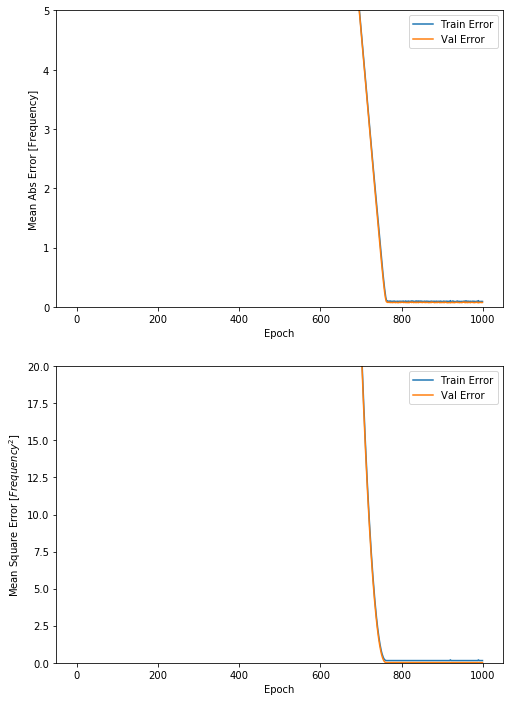

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Frequency]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Frequency^2$]')
    
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)


....................................................................................................
...................................................................................

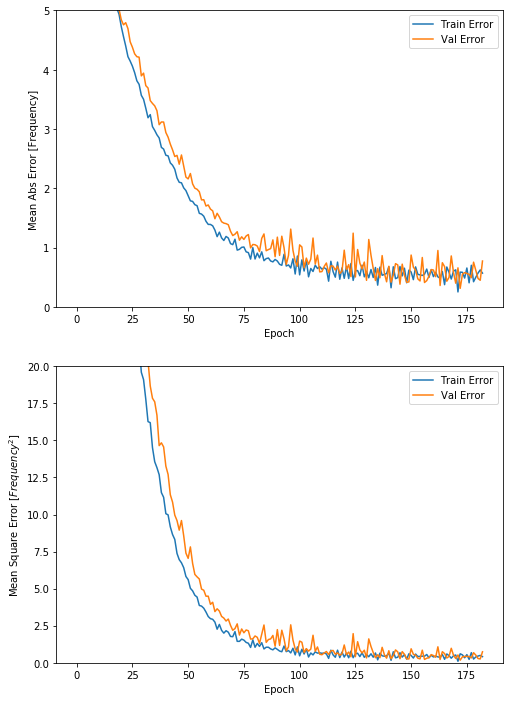

In [40]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [15]:
loss, mae, mse , accuracy = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} Frequency".format(mae))

100/100 - 0s - loss: 0.0486 - mae: 0.1009 - mse: 0.0486 - accuracy: 0.0000e+00
테스트 세트의 평균 절대 오차:  0.10 Frequency


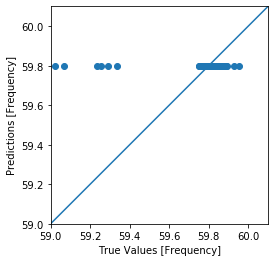

In [16]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Frequency]')
plt.ylabel('Predictions [Frequency]')
plt.axis('equal')
plt.axis('square')
plt.xlim([59,60.1])
plt.ylim([59,60.1])
_ = plt.plot([-1000, 1000], [-1000, 1000])


In [44]:
print(test_labels, test_predictions)

9      59.817591
11     59.748993
15     59.770735
16     59.750117
18     59.869273
         ...    
479    59.336271
490    59.781732
494    59.826743
497    59.773433
498    59.873778
Name: Frequency, Length: 100, dtype: float64 [59.66686  59.63653  59.600765 59.614967 59.656033 59.655525 59.603355
 59.65554  59.61703  59.644905 59.64013  59.65235  59.641273 59.642574
 59.620537 59.658703 59.64932  59.6537   59.64603  59.66101  59.627277
 59.653324 59.61026  59.65372  59.625065 59.63533  59.61543  59.6417
 59.612465 59.64921  59.61652  59.67182  59.600246 59.622894 59.618565
 59.67119  59.65407  59.653824 59.65997  59.630768 59.650364 59.61412
 59.61405  59.585155 59.588177 59.636375 59.664288 59.660183 59.675014
 59.661674 59.64104  59.633095 59.59753  59.657288 59.607994 59.664574
 59.627495 59.662193 59.650974 59.66708  59.651203 59.66484  59.6691
 59.675816 59.64814  59.596233 59.650948 59.61764  59.66927  59.66772
 59.643116 59.608715 59.60946  59.62555  59.60633  59.65111  59.

In [22]:
print()

[59.76182  59.699844 59.70872  59.72465  59.754475 59.475567 59.711132
 59.845856 60.242424 59.3172   59.72208  59.734188 60.31131  59.686924
 59.747147 59.71397  59.674305 59.769726 59.749817 59.775204 59.708065
 59.312717 59.86808  59.74434  60.051586 59.662426 59.574013 59.75394
 59.754906 59.945694 59.66027  59.731834 59.458557 59.77832  59.71023
 59.51312  59.516083 59.7961   59.72531  59.79506  59.855015 59.773144
 59.7936   59.71411  59.811268 59.62182  59.733543 59.73543  59.661617
 59.744583 59.608475 59.893574 59.682426 59.686054 59.701214 59.615902
 59.72284  59.788567 59.649437 60.40161  59.781578 59.208027 59.732292
 59.782894 59.768112 59.798744 59.75571  59.778725 59.48884  59.78979
 59.662136 59.545498 59.729332 59.76761  59.394913 59.90581  59.70374
 59.659645 60.13409  59.729145 59.70376  59.738277 59.724823 59.751274
 59.30717  59.776344 59.829784 59.45952  59.89835  59.55851  59.77161
 59.696335 59.762306 59.743893 60.104847 60.080585 59.720486 59.79745
 59.661327 5

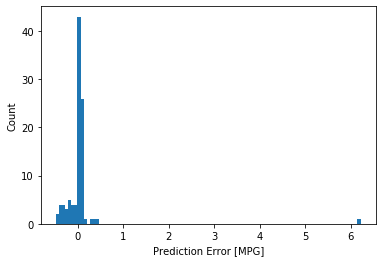

In [139]:
error = test_predictions - test_labels
plt.hist(error, bins = 100
        )
plt.xlabel("Prediction Error [Frequency]")
_ = plt.ylabel("Count")